# [5SSD0] Probabilistic Programming - Assignment [SOLUTION]

### Year: 2021-2022

Author: Wouter M. Kouw

---

In this assignment, you will apply polynomial regression to predict how much sound an airfoil makes during flight.

In [ ]:
using Pkg
Pkg.activate("workspace")
Pkg.instantiate();

In [2]:
using CSV
using Random
using LinearAlgebra
using DataFrames
using ProgressMeter
using ForneyLab
using Plots
pyplot();

### Problem: Airfoil self-noise

Among other matters, NASA studies how various design factors affect the noise an airfoil makes. In short, the way the wind travels past the foil creates vortices of different shapes. A vortex pushes and pulls the wing which causes it to oscillate and generate sound waves. The figure below shows two designs: a sharp trailing edge (left) and a blunt edge (right). 

<div> 
    <table>
        <tr>
            <td> <img src="figures/Airfoil-schematic-02.png"> </td>
            <td> <img src="figures/Airfoil-schematic-04.png"/> </td>
        </tr>
    </table>
</div>

NASA performed experiments with these airfoils in a windtunnel. They varied several design features, measured oscillation frequency and recorded sound amplitude levels. The results were published as a technical report and the data has been made publicly available ([data set](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise)). I have split it into training and test sets for this assignment.

Reference: [Brooks, Pope & Marcolini (1989). Airfoil self-noise and prediction, NASA RP 1218](https://ntrs.nasa.gov/api/citations/19890016302/downloads/19890016302.pdf)

For now, we will only consider regressing the feature "Frequency" onto the feature "Sound amplitude".

In [3]:
# Load training data
trn_data = DataFrame(CSV.File("data/airfoil_trn.csv"))
trn_input = log10.(trn_data[:,1])
trn_output = trn_data[:,6];
N = size(trn_data,1)

# Load test data
tst_data = DataFrame(CSV.File("data/airfoil_tst.csv"));
tst_input = log10.(tst_data[:,1])
tst_output = tst_data[:,6];
M = size(tst_data,1);

Let's visualize this relationship.

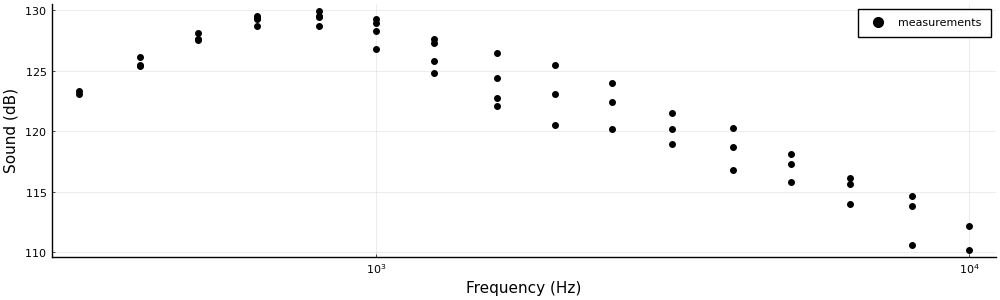

In [4]:
scatter(trn_data[:,1], trn_output, size=(1000,300), color="black", xscale=:log10, xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="measurements")

At first glance, there seems to be a nonlinear relation between these two variables. But it's still relatively smooth, so we don't need a highly flexible function approximator. A polynomial should fit nicely.

### Polynomial regression

We can fit a curve by applying a polynomial basis expansion to the data points. To fit a polynomial of order $d$, we define a basis expansion function $\phi : \mathbb{R} \rightarrow \mathbb{R}^{d+1}$, where 

$$\phi(x) = \begin{bmatrix} 1 & x & x^2 & x^3 & \dots & x^d \end{bmatrix} \, .$$

Our regression model will be:

$$ y_k = \sum_{i=1}^{d+1} \theta_i \phi_i(x_k) + e_k \, ,$$ 

where $\phi_i(x)$ indicates the $i$-th element of the expanded vector. The noise follows a zero-mean Gaussian distribution with precision parameter $\tau$: 

$$e_k \sim \mathcal{N}(0, \tau^{-1}) \, .$$ 

Note that although this model is polynomial in the data, it remains linear in the coefficients. Our goal will be to estimate appropriate coefficients and make accurate predictions for future data points.

A useful step is to precompute the polynomial expansion for all data points:

$$ V = \begin{bmatrix} 1 & x_1 & x_1^2 & \dots x_1^d \\
                       1 & x_2 & x_2^2 & \dots x_2^d \\
                       \vdots & \vdots & \ddots & \vdots \\ 
                       1 & x_N & x_N^2 & \dots x_N^d \end{bmatrix} \quad .$$
                       
This is called a [Vandermonde](https://en.wikipedia.org/wiki/Vandermonde_matrix) matrix. Below is an example of how to make one:

In [5]:
# Polynomial order
d = 3

# Polynomial basis function
ϕ(x) = [x.^j for j in 0:d]

# Vandermonde matrix
V = hcat(ϕ(trn_input)...)

51×4 Matrix{Float64}:
 1.0  2.79934   7.83631  21.9365
 1.0  2.90309   8.42793  24.467
 1.0  3.0       9.0      27.0
 1.0  3.09691   9.59085  29.702
 1.0  3.20412  10.2664   32.8947
 1.0  3.30103  10.8968   35.9707
 1.0  3.39794  11.546    39.2326
 1.0  3.49831  12.2382   42.8129
 1.0  3.60206  12.9748   46.7361
 1.0  3.69897  13.6824   50.6107
 1.0  3.79934  14.435    54.8434
 1.0  3.90309  15.2341   59.4601
 1.0  4.0      16.0      64.0
 ⋮                       
 1.0  3.60206  12.9748   46.7361
 1.0  3.69897  13.6824   50.6107
 1.0  3.79934  14.435    54.8434
 1.0  3.90309  15.2341   59.4601
 1.0  2.49831   6.24156  15.5933
 1.0  2.60206   6.77072  17.6178
 1.0  2.69897   7.28444  19.6605
 1.0  2.79934   7.83631  21.9365
 1.0  2.90309   8.42793  24.467
 1.0  3.0       9.0      27.0
 1.0  3.09691   9.59085  29.702
 1.0  3.20412  10.2664   32.8947

## [2pt] Question 1 

- Specify a polynomial regression model of order $d= 3$ using ForneyLab.jl. 
- Define a message passing algorithm. 
- Infer a posterior distribution for the coefficients. 

For now, you may fix the precision of the likelihood function as follows: Calculate the variance of the observed signal per distinct frequency level, invert that and average over the obtained values.

In [6]:
# Separately estimated precision
τ_hat = mean([inv(var(trn_output[trn_input .== f])) for f in unique(trn_input)])

5.220618618560568

In [7]:
# Start factor graph
graph = FactorGraph();

# Polynomial order
d = 3

# Basis expansion function
ϕ(x) = [x.^j for j in 0:d]

# Prior parameters
μ_θ = [100, 0, 0, 0]
Λ_θ = 1e-3*Matrix{Float64}(I,d+1,d+1)

# Coefficient prior 
@RV θ ~ GaussianMeanPrecision(μ_θ, Λ_θ)

# Pre-define vectors
Φ = Vector{Variable}(undef, N) 
y = Vector{Variable}(undef, N)

# Iterate over samples
for i = 1:N
    
    # Input (basis expanded frequency)
    @RV Φ[i]
    
    # Output (sound amplitude level)
    @RV y[i] ~ GaussianMeanPrecision(dot(θ,Φ[i]), τ_hat)

    # Designate observed variables
    placeholder(Φ[i], :Φ, index=i, dims=(d+1,))
    placeholder(y[i], :y, index=i);
    
end

# Define and compile the algorithm
algorithm = messagePassingAlgorithm(θ) 
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code));

# Load data
data = Dict(:Φ => [ϕ(trn_input[i]) for i in 1:N],
            :y => trn_output)

# Infer posterior
posterior = step!(data);

The following cells visualize the regression function with your computed MAP estimate.

In [8]:
# Extract maximum a posteriori (MAP) estimate from the posterior distribution
θ_MAP = ForneyLab.unsafeMode(posterior[:θ]);

The `unsafe..` functions used above is a ForneyLab internal method to deal with potential numerical instabilities.

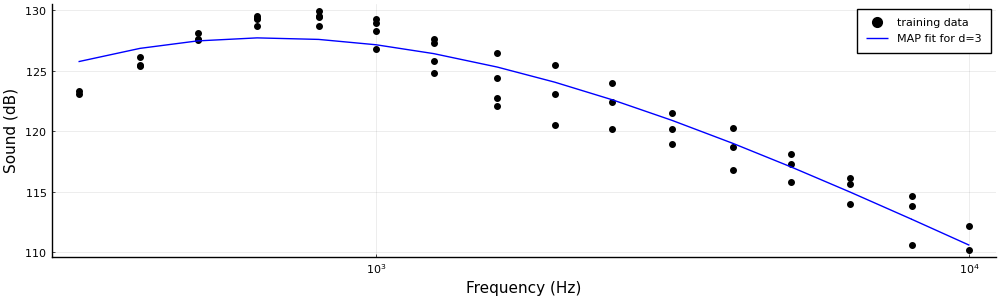

In [9]:
# Generate Vandermonde matrix for training data
V_trn = hcat(ϕ(trn_input)...);

# Sorted index for training inputs (necessary for plotting a line)
sortedix_trn = sortperm(trn_input)

# Visualize fit of current MAP estimate in model
scatter(trn_data[:,1], trn_output, size=(1000,300), color="black", xscale=:log10, xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="training data")
plot!(trn_data[sortedix_trn,1], V_trn[sortedix_trn,:]*θ_MAP, markersize=10, color="blue", size=(1000,300), label="MAP fit for d=3")

## [1pt] Question 2

- Compute the posterior predictive distribution for each test data point.
- Scatter the test data points (frequency in `xscale=:log10` on x-axis, sound on y-axis).
- Add the means of the posterior predictive distributions as a solid line.
- Add the prediction uncertainty margin of +/- $\sigma$ around the means (use the `ribbon=` keyword argument for this purpose).

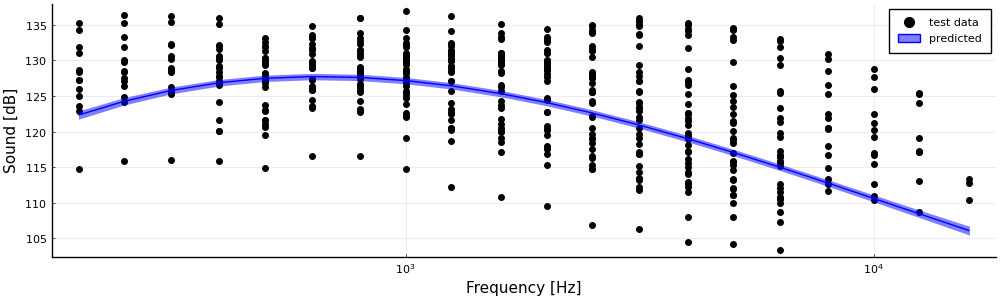

In [10]:
# Extract parameters of posterior distribution
μ_θ = ForneyLab.unsafeMean(posterior[:θ]);
Σ_θ = ForneyLab.unsafeCov(posterior[:θ]);

# Generate Vandermonde matrix for test data
V_tst = hcat(ϕ(tst_input)...);

# Compute the parameters of the posterior predictive distribution for the test data
ppred1_μ = zeros(M)
ppred1_σ = zeros(M)
for j = 1:M
    ppred1_μ[j] = V_tst[j,:]'*μ_θ
    ppred1_σ[j] = sqrt(V_tst[j,:]'*Σ_θ*V_tst[j,:] + inv(τ_hat))
end

# Sorted index for test inputs (necessary for plotting a line)
sortedix_tst = sortperm(tst_input)

# Scatter test data and plot the posterior predictive distributions
scatter(tst_data[:,1], tst_output, color="black", xscale=:log10, label="test data", xlabel="Frequency [Hz]", ylabel="Sound [dB]")
plot!(tst_data[sortedix_tst,1], ppred1_μ[sortedix_tst], ribbon=ppred1_σ[sortedix_tst], color="blue", size=(1000,300), label="predicted")

## [1pt] Question 3

- Compute the maximum likelihood (ML) estimate on the training data set.
- Scatter the test data points (frequency in `xscale=:log10` on x-axis, sound on y-axis).
- Add the predictions of the ML estimate as a solid line.
- Compute and compare the mean squared errors for both the ML and MAP estimates. 

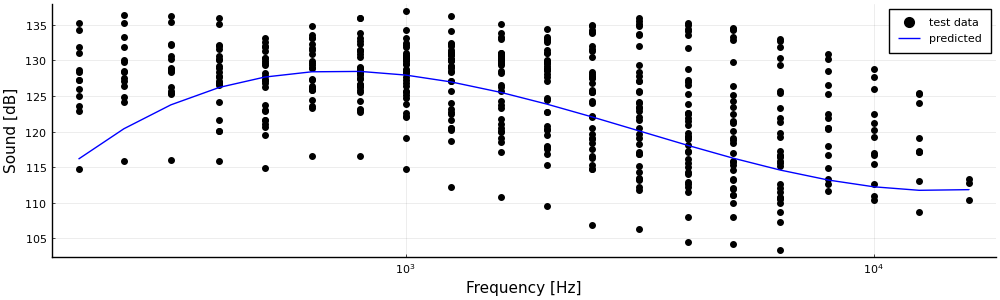

In [11]:
# Compute ML estimate
θ_ML = inv(V_trn'*V_trn)*(V_trn'*trn_output);

# Scatter test data and plot the posterior predictive distributions
scatter(tst_data[:,1], tst_output, color="black", xscale=:log10, label="test data", xlabel="Frequency [Hz]", ylabel="Sound [dB]")
plot!(tst_data[sortedix_tst,1], V_tst[sortedix_tst,:]*θ_ML, xscale=:log10, markersize=10, color="blue", size=(1000,300), label="predicted")

In [12]:
println("MSE MAP = "*string(mean((V_tst*θ_MAP .- tst_output).^2)))
println("MSE ML  = "*string(mean((V_tst*θ_ML .- tst_output).^2)))

MSE MAP = 46.761204061990924
MSE ML  = 50.40923695231228


## [3pt] Question 4

We will now treat the precision of the likelihood function as an unknown variable (i.e., we will no longer fix it using a separate estimation procedure).

- Specify a probabilistic model where the unknown likelihood precision is given an appropriate prior distribution, with parameters chosen by you. 
- Define a message passing procedure to simultaneously estimate coefficients and likelihood precision.
- Infer a posterior distribution for the coefficients and the likelihood precision.

In [13]:
# Start factor graph
graph = FactorGraph();

# Polynomial order
d = 3

# Basis expansion function
ϕ(x) = [x.^j for j in 0:d]

# Prior coefficient parameters
μ_θ = [100, 0, 0, 0]
Λ_θ = 1e-4*Matrix{Float64}(I,d+1,d+1)

# Prior precision parameters
α_τ = 1.0
β_τ = 0.1

# Noise precision prior
@RV τ ~ Gamma(α_τ, β_τ)

# Coefficient prior
@RV θ ~ GaussianMeanPrecision(μ_θ, Λ_θ)

# Pre-define vectors
Φ = Vector{Variable}(undef, N) 
y = Vector{Variable}(undef, N)

# Iterate over samples
for i = 1:N
    
    # Define i-th covariate
    @RV Φ[i]
    
    # Define likelihood of i-th response
    @RV y[i] ~ GaussianMeanPrecision(dot(θ,Φ[i]), τ)

    # Designate observed variables
    placeholder(Φ[i], :Φ, index=i, dims=(d+1,))
    placeholder(y[i], :y, index=i);
    
end

# Define and compile the algorithm
q = PosteriorFactorization(θ, τ, ids=[:θ, :τ])
algorithm = messagePassingAlgorithm() 
source_code = algorithmSourceCode(algorithm)
eval(Meta.parse(source_code));

# Initialize posterior 
posterior = Dict()
posterior[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=μ_θ, w=Λ_θ)
posterior[:τ] = ProbabilityDistribution(Univariate, Gamma, a=α_τ, b=β_τ)

# Load data
data = Dict(:Φ => [ϕ(trn_input[i]) for i in 1:N],
            :y => trn_output)

# Iterate recognition factor updates
for _ in 1:10
    stepθ!(data, posterior)
    stepτ!(data, posterior)
end

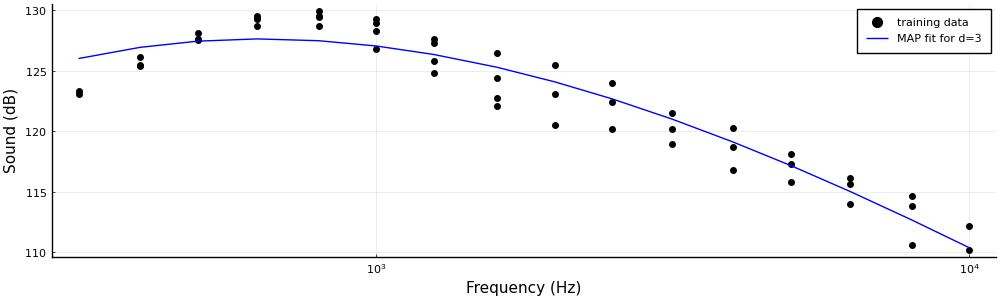

In [14]:
# Extract maximum a posteriori (MAP) estimate from posterior
θ_MAP = ForneyLab.unsafeMode(posterior[:θ]);

# Vandermonde matrix
V_trn = hcat(ϕ(trn_input)...)

# Visualize fit of current MAP estimate on training data
scatter(trn_data[:,1], trn_output, size=(1000,300), color="black", xscale=:log10, xlabel="Frequency (Hz)", ylabel="Sound (dB)", label="training data")
plot!(trn_data[sortedix_trn,1], V_trn[sortedix_trn,:]*θ_MAP, color="blue", label="MAP fit for d="*string(d))

## [1pt] Question 5 

- Compute the posterior predictive distribution for each test data point. Normally that would require marginalizing over the precision posterior distribution. You may use a simple approximation instead: fix the precision with the MAP estimate.
- Scatter the test data points (frequency in `xscale=:log10` on x-axis, sound on y-axis).
- Add the means of the posterior predictive distributions as a solid line.
- Add the prediction uncertainty margin of +/- $\sigma$ around the means (use the `ribbon=` keyword argument for this purpose).

Hint: if `ForneyLab.unsafeMode()` doesn't work, then you can extract the posterior parameters and compute the mode according to any of the expressions given in Appendix B of [Bishop's Pattern Recognition & Machine Learning](https://www.microsoft.com/en-us/research/uploads/prod/2006/01/Bishop-Pattern-Recognition-and-Machine-Learning-2006.pdf).

In [15]:
# Parameters of coefficient posterior
μ_θ = ForneyLab.unsafeMean(posterior[:θ]);
Σ_θ = ForneyLab.unsafeCov(posterior[:θ]);

# Parameters of precision posterior
α_τ = posterior[:τ].params[:a]
β_τ = posterior[:τ].params[:b];

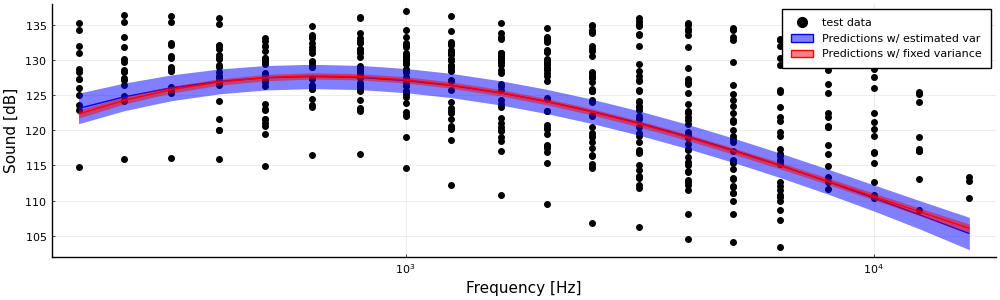

In [16]:
# Compute the parameters of the posterior predictive for the test data
ppred2_μ = zeros(M)
ppred2_σ = zeros(M)
for j = 1:M
    ppred2_μ[j] = V_tst[j,:]'*μ_θ
    ppred2_σ[j] = sqrt(V_tst[j,:]'*Σ_θ*V_tst[j,:] + inv((α_τ-1)/β_τ))
end

# Scatter test data and plot the posterior predictive distributions
scatter(tst_data[:,1], tst_output, color="black", xscale=:log10, label="test data", xlabel="Frequency [Hz]", ylabel="Sound [dB]")
plot!(tst_data[sortedix_tst,1], ppred2_μ[sortedix_tst], ribbon=ppred2_σ[sortedix_tst], color="blue", size=(1000,300), label="Predictions w/ estimated var")
plot!(tst_data[sortedix_tst,1], ppred1_μ[sortedix_tst], ribbon=ppred1_σ[sortedix_tst], xscale=:log10, color="red", label="Predictions w/ fixed variance")

## [2pt] Question 6

- Alter the inference procedure defined for Question 4 to also compute free energy.
- Run the model for polynomials of order $d = 1, \dots, 5$ and store the free energy for each model.
- Select the model with the smallest free energy and report the order of the polynomial.

In [17]:
# Prior coefficient parameters
μ_θ = [100, 0, 0, 0, 0, 0]
Λ_θ = 1e-4*Matrix{Float64}(I,6,6)

# Prior precision parameters
α_τ = 1.0
β_τ = 0.1

# Number of iterations
num_iterations = 4

# Preallocate free energy array
FE = zeros(5, num_iterations)

# Loop over polynomial orders
@showprogress for d = 1:5
    
    # Basis expansion function
    ϕ(x) = [x.^j for j in 0:d]

    # Start factor graph
    graph = FactorGraph();

    # Noise precision prior
    @RV τ ~ Gamma(α_τ, β_τ)

    # Coefficient prior
    @RV θ ~ GaussianMeanPrecision(μ_θ[1:d+1], Λ_θ[1:d+1,1:d+1])

    # Pre-define vectors
    Φ = Vector{Variable}(undef, N) 
    y = Vector{Variable}(undef, N)

    # Iterate over samples
    for i = 1:N

        # Define i-th covariate
        @RV Φ[i]

        # Define likelihood of i-th response
        @RV y[i] ~ GaussianMeanPrecision(dot(θ,Φ[i]), τ)

        # Designate observed variables
        placeholder(Φ[i], :Φ, index=i, dims=(d+1,))
        placeholder(y[i], :y, index=i);

    end

    # Define and compile the algorithm
    q = PosteriorFactorization(θ, τ, ids=[:θ, :τ])
    algorithm = messagePassingAlgorithm(free_energy=true) 
    source_code = algorithmSourceCode(algorithm, free_energy=true)
    eval(Meta.parse(source_code));

    # Initialize posterior 
    posterior = Dict()
    posterior[:θ] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=μ_θ, w=Λ_θ)
    posterior[:τ] = ProbabilityDistribution(Univariate, Gamma, a=α_τ, b=β_τ)

    # Load data
    data = Dict(:Φ => [ϕ(trn_input[i]) for i in 1:N],
                :y => trn_output)

    for k in 1:num_iterations

        # Update recognition factors
        stepθ!(data, posterior)
        stepτ!(data, posterior)

        # Compute free energy
        FE[d,k] = freeEnergy(data, posterior)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


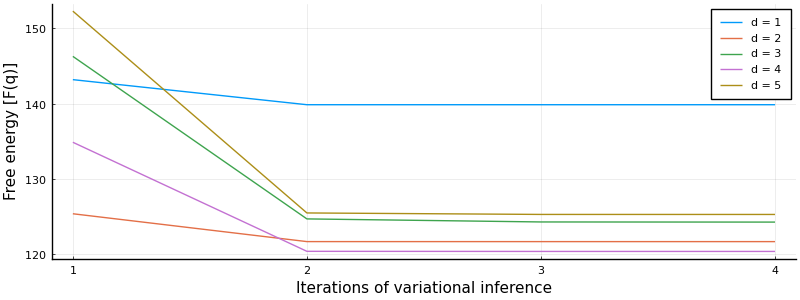

In [18]:
plot(1:num_iterations, FE', xlabel="Iterations of variational inference", ylabel="Free energy [F(q)]", labels=["d = 1" "d = 2" "d = 3" "d = 4" "d = 5"], size=(800,300))

In [19]:
println("FE indicates d = "*string(argmin(FE[:,end]))*" is optimal.")

FE indicates d = 4 is optimal.
